In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,RandomizedSearchCV

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score

In [218]:
df = pd.read_csv("train.csv")
df.head()
print(df.PassengerId.isnull().sum())
df.columns

0


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [219]:
print(
    df.Survived.isnull().sum(),
    df.Sex.isnull().sum()
    
)


0 0


In [220]:
df['Family'] = df['Parch']+df['SibSp']

In [221]:
df['Title'] = df.Name.str.extract(r'(Mr|Mrs|Ms)\.')

In [222]:
df['Title'].isnull().sum()

np.int64(248)

In [223]:
df['Title'] = df.apply(lambda row : 'Mr' if pd.isnull(row['Title']) and row['Sex'] == 'male' else
   ('Mrs' if pd.isnull(row['Title']) and row['Sex'] == 'female' else row['Title'] ), axis = 1)

In [224]:
df = df.drop(['Ticket','Fare','Cabin','SibSp','Parch','Name'],axis = 1)

In [225]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Embarked', 'Family',
       'Title'],
      dtype='object')

In [226]:
df = df.replace(
    {'Sex':
    {
        'male':0,
        'female':1
    },
    'Embarked':
    {
        'S':0,
        'Q':1,
        'C':2

    },
    'Title':
    {
        'Mr':0,
        'Mrs':1,
        'Ms':2

    }



})

C:\Users\ACER\AppData\Local\Temp\ipykernel_5656\3278901010.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [227]:
df.Age.isnull().sum()

np.int64(177)

In [228]:
df.Pclass.isnull().sum()

np.int64(0)

In [229]:
df.Age = df.Age.fillna(df.Age.mode()[0])

Text(0.5, 1.0, 'HeatMap')

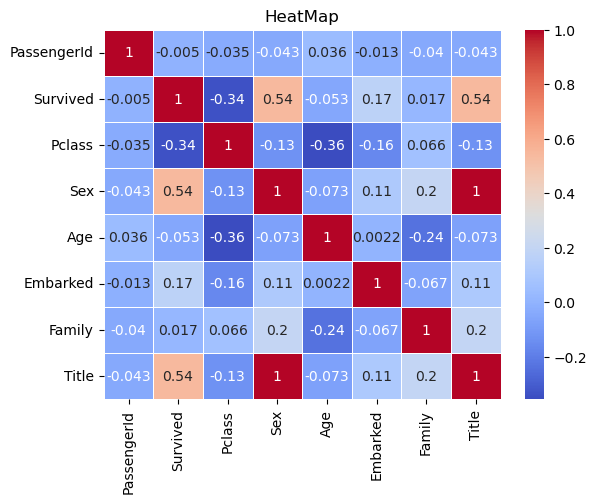

In [230]:
numeric_columns = df.select_dtypes(include=['number'])
corr = numeric_columns.corr()
sns.heatmap(corr,annot = True,cmap = 'coolwarm',linewidth = 0.5)
plt.title("HeatMap")

In [231]:
X = df.drop(['PassengerId','Survived','Pclass'],axis = 1)
Y = df.Survived

In [232]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2 , random_state = 45)

In [233]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # Split quality measure
    'splitter': ['best', 'random'],    # Split strategy
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required in each leaf
    'max_features': [None,  'sqrt', 'log2', 1, 2],  # Features to consider for splig
    'random_state': [45],  # For reproducibility
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(class_weight="balanced")

# Initialize GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1,error_score='raise')

# Train the model using GridSearchCV
grid_search.fit(X_train, Y_train)

# Get the best parameters and the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 45, 'splitter': 'random'}


In [234]:
cm = confusion_matrix(Y_test,y_pred)
print(cm)
print(accuracy_score(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(roc_auc_score(Y_test,y_pred))

[[99 18]
 [12 50]]
0.8324022346368715
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       117
           1       0.74      0.81      0.77        62

    accuracy                           0.83       179
   macro avg       0.81      0.83      0.82       179
weighted avg       0.84      0.83      0.83       179

0.826302729528536


In [235]:
sar = StratifiedKFold(n_splits = 5)
cross_val_score(best_model,X,Y,cv = sar )

array([0.82681564, 0.81460674, 0.81460674, 0.78089888, 0.8258427 ])

In [236]:
param_dist = {
    'criterion': ['gini', 'entropy'],  # Split quality measure
    'splitter': ['best', 'random'],    # Split strategy
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required in each leaf
    'max_features': [None, 'sqrt', 'log2', 1, 2],  # Features to consider for split
    'random_state': [45],  # For reproducibility
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(class_weight="balanced")

# Initialize RandomizedSearchCV with cross-validation (cv=5)
random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=45, error_score='raise')

# Train the model using RandomizedSearchCV
random_search.fit(X_train, Y_train)

# Get the best parameters and the best model
print(f"Best Parameters: {random_search.best_params_}")
best_model2 = random_search.best_estimator_

# Make predictions with the best model
y_pred2 = best_model.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'splitter': 'random', 'random_state': 45, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 10, 'criterion': 'gini'}


In [237]:
cm = confusion_matrix(Y_test,y_pred2)
print(cm)
print(accuracy_score(Y_test,y_pred2))
print(classification_report(Y_test,y_pred2))
print(roc_auc_score(Y_test,y_pred2))

[[99 18]
 [12 50]]
0.8324022346368715
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       117
           1       0.74      0.81      0.77        62

    accuracy                           0.83       179
   macro avg       0.81      0.83      0.82       179
weighted avg       0.84      0.83      0.83       179

0.826302729528536


In [238]:
sar = StratifiedKFold(n_splits = 10)
cross_val_score(best_model2,X,Y,cv = sar )

array([0.8       , 0.84269663, 0.75280899, 0.82022472, 0.79775281,
       0.80898876, 0.80898876, 0.74157303, 0.85393258, 0.86516854])

In [239]:
df2 = pd.read_csv('titanictest.csv')

In [240]:
df2.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [241]:
df2['Family'] = df2['Parch']+df2['SibSp']
df2['Title'] = df2.Name.str.extract(r'(Mr|Mrs|Ms)\.')
df2['Title'] = df2.apply(lambda row : 'Mr' if pd.isnull(row['Title']) and row['Sex'] == 'male' else
   ('Mrs' if pd.isnull(row['Title']) and row['Sex'] == 'female' else row['Title'] ), axis = 1)


In [242]:
df2.Title.isnull().sum()

np.int64(0)

In [243]:
df2.Age.isnull().sum()

np.int64(86)

In [244]:
df2.Age = df2.Age.fillna(df2.Age.mode()[0])

In [245]:
df2 = df2.replace(
    {'Sex':
    {
        'male':0,
        'female':1
    },
    'Embarked':
    {
        'S':0,
        'Q':1,
        'C':2

    },
    'Title':
    {
        'Mr':0,
        'Mrs':1,
        'Ms':2

    }



})

C:\Users\ACER\AppData\Local\Temp\ipykernel_5656\2632603502.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace(


In [246]:
df2 = df2.drop(['Pclass','Fare','Ticket','Cabin','Parch','SibSp','Name'],axis = 1)

In [247]:

df2.columns

Index(['PassengerId', 'Sex', 'Age', 'Embarked', 'Family', 'Title'], dtype='object')

In [248]:
df2.Family.isnull().sum()
df2.Age.isnull().sum()

np.int64(0)

In [249]:
df2.Embarked.unique()
df2.Sex.unique()
df2.Title.unique()

array([0, 1, 2])

In [250]:
Xl = df2.drop(['PassengerId'],axis = 1)

In [251]:
y_out = best_model2.predict(Xl)

In [252]:
sub = pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':y_out})

In [253]:
sub.to_csv('submit_titanic2.csv',index = False)